In [1]:
import os
import slam.io as sio
import slam.topology as stop
import slam.plot as splt
import slam.mapping as smap
import slam.differential_geometry as sdg
import numpy as np
import networkx as nx
import argparse
import pickle

from visbrain.gui import Brain
from visbrain.objects import SourceObj, ConnectObj
from visbrain.io import download_file


def get_visb_sc_shape(visb_sc):
    """
    get the subplot shape in a visbrain scene
    :param visb_sc:
    :return: tuple (number of rows, number of coloumns)
    """
    k = list(visb_sc._grid_desc.keys())
    return k[-1]


def graph_edges_to_connect(graph, edge_attribute=None, nodes_mask=None):

    if edge_attribute is None:
         attr_mat= nx.adjacency_matrix(graph)
         conn_mat = attr_mat.todense()
    else:
        attr_mat = nx.attr_matrix(graph, edge_attr=edge_attribute)
        conn_mat = attr_mat[0]
    if nodes_mask is not None:
        print(nodes_mask.shape)
        conn_mat = np.delete(conn_mat, np.where(nodes_mask==False)[0], 0)
        conn_mat = np.delete(conn_mat, np.where(nodes_mask==False)[0], 1)
        print(conn_mat.shape)
    connect = np.ma.masked_array(np.array(conn_mat), False)
    #connect.mask[np.tril_indices_from(connect.mask)] = True
    return connect


def graph_nodes_to_coords(graph, index_attribute, mesh):
    vert_indices = list(nx.get_node_attributes(graph, index_attribute).values())
    coords = np.array(mesh.vertices[vert_indices, :])
    return coords


def graph_nodes_attribute(graph, attribute):
    att = list(nx.get_node_attributes(graph, attribute).values())
    return np.array(att)


def remove_dummy_nodes(graph):
    is_dummy = graph_nodes_attribute(graph, 'is_dummy')
    if True in is_dummy:
        graph_copy = graph.copy()
        graph_copy.remove_nodes_from(np.where(np.array(is_dummy)==True)[0])
        return graph_copy
    else:
        return graph


def show_graph(graph, mesh, nodes_color='red', edge_attribute=None, mask_slice_coord=None):
    print('total nb nodes',len(graph))
    graph_no_dummy = remove_dummy_nodes(graph)
    print('after removing dummy nodes',len(graph_no_dummy))
    # manage nodes
    s_coords = graph_nodes_to_coords(graph_no_dummy, 'ico100_7_vertex_index', mesh)
    if mask_slice_coord is not None:
        print(s_coords.shape)
        nodes_mask = s_coords[:, 2]>mask_slice_coord
        s_coords = s_coords[nodes_mask, :]
        print(np.sum(nodes_mask))
        print(s_coords.shape)
    else:
        nodes_mask=None
    connect = graph_edges_to_connect(graph_no_dummy, edge_attribute, nodes_mask)

    s_obj = SourceObj('S_left', s_coords, color=nodes_color,
                        edge_color='black', symbol='disc', edge_width=2.,
                        radius_min=20., radius_max=30., alpha=.4)


    # manage edges

    #A = nx.adjacency_matrix(graph)
    c_obj = ConnectObj('C_left', s_coords, connect, select=connect>0)
    # c_obj = ConnectObj('C_left', s_coords, connect, color_by='strength',
    #                      cmap='viridis', vmin=0., vmax=.1,
    #                      under='gray', over='red')

    return s_obj, c_obj


def visbrain_plot(mesh, tex=None, caption=None, cblabel=None, visb_sc=None,
                  cmap='jet'):
    """
    Visualize a trimesh object using visbrain core plotting tool
    :param mesh: trimesh object
    :param tex: numpy array of a texture to be visualized on the mesh
    :return:
    """
    from visbrain.objects import BrainObj, ColorbarObj, SceneObj
    b_obj = BrainObj('gui', vertices=np.array(mesh.vertices),
                     faces=np.array(mesh.faces),
                     translucent=False,
                     hemisphere="both")
    #b_obj.rotate(fixed="bottom", scale_factor=0.02)
    if visb_sc is None:
        visb_sc = SceneObj(bgcolor='white', size=(1400, 1000))
        visb_sc.add_to_subplot(b_obj, title=caption)
        visb_sc_shape = (1, 1)
    else:
        visb_sc_shape = get_visb_sc_shape(visb_sc)
        visb_sc.add_to_subplot(b_obj, row=visb_sc_shape[0] - 1,
                               col=visb_sc_shape[1], title=caption)

    if tex is not None:
        b_obj.add_activation(data=tex, cmap=cmap,
                             clim=(np.min(tex), np.max(tex)))
        CBAR_STATE = dict(cbtxtsz=20, txtsz=20., width=.1, cbtxtsh=3.,
                          rect=(-.3, -2., 1., 4.), cblabel=cblabel)
        cbar = ColorbarObj(b_obj, **CBAR_STATE)
        visb_sc.add_to_subplot(cbar, row=visb_sc_shape[0] - 1,
                               col=visb_sc_shape[1] + 1, width_max=200)
    return visb_sc


def load_graphs_in_list(path_to_graphs_folder):
    """
    Return a list of graph loaded from the path
    """
    list_graphs = []
    graph_files = []
    list_files = os.listdir(path_to_graphs_folder)
    for fil in list_files:
        if 'graph_' in fil:
            graph_files.append(fil)
    for graph_file in graph_files:
        path_graph = os.path.join(path_to_graphs_folder, graph_file)
        graph = nx.read_gpickle(path_graph)
        list_graphs.append(graph)
    return list_graphs


def list_to_dict(list_in):
    """
    converter used for pitsgraph to networkx conversion
    :param array:
    :return:
    """
    D = {}
    for i, l_i in enumerate(list_in):
        D[i] = l_i
    return D


def sphere_nearest_neighbor_interpolation(graph, vert_sphere_template):
    """
    For each pit on the individual sphere.reg stored in vert_pits,
    find the closest point in the template sphere coordinates stored in vert_template
    :param vert_template:
    :param vert_pits:
    :return:indices of the nearest neighors of vert_pits in vert_template
    """

    nodes_coords = graph_nodes_attribute(graph, 'coord')
    vertex_number1 = vert_sphere_template.shape[0]


    #print('vert_template.shape', vert_template.shape[0])
    #print('vert_pits.shape', vert_pits.shape[0])
    nn = np.zeros(nodes_coords.shape[0], dtype=np.int64)
    for ind, v in enumerate(nodes_coords):
        #print(v)
        nn_tmp = np.argmin(np.sum(np.square(np.tile(v, (vertex_number1, 1)) - vert_sphere_template), 1))
        nn[ind] = nn_tmp
    #print(nodes_coords.shape)
    #print(len(nn))
    nx.set_node_attributes(graph, list_to_dict(nn), 'ico100_7_vertex_index')
    return graph

def reg_mesh(mesh):
    # flip
    transfo_full = np.array([[-1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0], [0, 0, 0, 1]])
    mesh.apply_transform(transfo_full)
    # Rz(90)
    transfo_full = np.array([[0, -1, 0, 0],[1, 0, 0, 0],[0, 0, 1, 0], [0, 0, 0, 1]])
    mesh.apply_transform(transfo_full)
    # Rx(-90)
    transfo_full = np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0], [0, 0, 0, 1]])
    mesh.apply_transform(transfo_full)
    mesh.vertices = mesh.vertices - np.mean(mesh.vertices, 0)
    return mesh

4


SourceObj(name='S_left') created
    70 sources detected
ConnectObj(name='C_left') created
    70 nodes detected
    strength coloring method for connectivity
    366 connectivity links displayed
BrainObj(name='gui') created


total nb nodes 95
after removing dummy nodes 95
(95, 3)
70
(70, 3)
(95,)
(70, 70)


Creation of a scene
    BrainObj(name='gui') added to the scene
    SourceObj(name='S_left') added to the scene
    ConnectObj(name='C_left') added to the scene
SourceObj(name='S_left') created
    68 sources detected
ConnectObj(name='C_left') created
    68 nodes detected
    strength coloring method for connectivity
    360 connectivity links displayed
BrainObj(name='gui') created


total nb nodes 95
after removing dummy nodes 95
(95, 3)
68
(68, 3)
(95,)
(68, 68)


    BrainObj(name='gui') added to the scene
    SourceObj(name='S_left') added to the scene
    ConnectObj(name='C_left') added to the scene
SourceObj(name='S_left') created
    68 sources detected
ConnectObj(name='C_left') created
    68 nodes detected
    strength coloring method for connectivity
    342 connectivity links displayed
BrainObj(name='gui') created


total nb nodes 95
after removing dummy nodes 95
(95, 3)
68
(68, 3)
(95,)
(68, 68)


    BrainObj(name='gui') added to the scene
    SourceObj(name='S_left') added to the scene
    ConnectObj(name='C_left') added to the scene
SourceObj(name='S_left') created
    62 sources detected
ConnectObj(name='C_left') created
    62 nodes detected
    strength coloring method for connectivity
    318 connectivity links displayed
BrainObj(name='gui') created


total nb nodes 85
after removing dummy nodes 85
(85, 3)
62
(62, 3)
(85,)
(62, 62)


    BrainObj(name='gui') added to the scene
    SourceObj(name='S_left') added to the scene
    ConnectObj(name='C_left') added to the scene
WARNING | dpi parameter is not active if `print_size` is None. Use for example `print_size=(5, 5)`


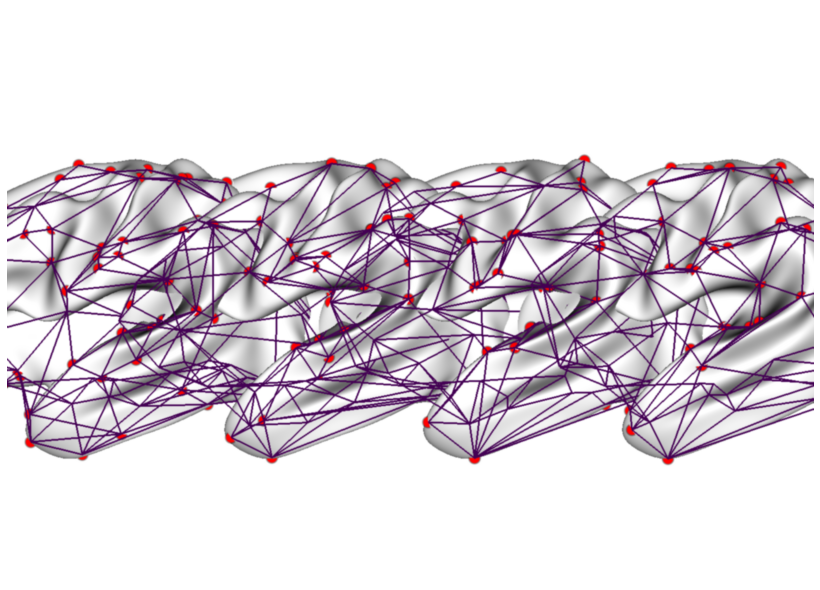

In [6]:
if __name__ == "__main__":
    template_mesh = '/home/rohit/PhD_Work/stage_nathan/data/template_mesh/lh.OASIS_testGrp_average_inflated.gii'
    #path_to_graphs = '/mnt/data/work/python_sandBox/stage_nathan/data/simu_graphs/with_ref_for_visu/noise_100,outliers_0/0/graphs'
    #path_to_graphs = '/mnt/data/work/python_sandBox/stage_nathan/data/simu_graphs/noise_10_outliers_25'
    sphere_template_mesh = '/home/rohit/PhD_Work/stage_nathan/data/ico100_7.gii'
    #runs=[0, 1, 2, 3,4,5]#[6, 7, 8, 9]
    runs=[0]
    for simus_run in runs:
        #path_to_graphs = '/mnt/data/work/python_sandBox/stage_nathan/data/simu_graphs/with_ref_for_visu/nb_vertices_85_noise_50_outliers_10/'+str(simus_run)+'/graphs'
        path_to_graphs = '/home/rohit/PhD_Work/stage_nathan/data/nb_vertices_85_noise_50_outliers_10/'+str(simus_run)+'/graphs'


        list_graphs = load_graphs_in_list(path_to_graphs)
        path_graph = os.path.join(path_to_graphs, "reference.gpickle")
        graph_ref = nx.read_gpickle(path_graph)
        list_graphs.append(graph_ref)

        print(len(list_graphs))
        # Get the mesh
        sphere_mesh = sio.load_mesh(sphere_template_mesh)

        interp_list_graphs = [sphere_nearest_neighbor_interpolation(g, sphere_mesh.vertices) for g in list_graphs]


        mesh = reg_mesh(sio.load_mesh(template_mesh))

        #mesh = sphere_mesh
        vb_sc = None
        for g in interp_list_graphs[:-1]:
            #s_obj, c_obj = show_graph(g, mesh, 'red', edge_attribute='geodesic_distance', mask_slice_coord=-15)
            s_obj, c_obj = show_graph(g, mesh, 'red', edge_attribute=None, mask_slice_coord=-15)
            vb_sc = visbrain_plot(mesh, visb_sc=vb_sc)
            visb_sc_shape = get_visb_sc_shape(vb_sc)
            vb_sc.add_to_subplot(s_obj, row=visb_sc_shape[0] - 1, col=visb_sc_shape[1]- 1)
            vb_sc.add_to_subplot(c_obj, row=visb_sc_shape[0] - 1, col=visb_sc_shape[1]- 1)

            # vb_sc.preview()


        #s_obj, c_obj = show_graph(interp_list_graphs[-1], mesh, 'green', edge_attribute='geodesic_distance', mask_slice_coord=-15)
        s_obj, c_obj = show_graph(interp_list_graphs[-1], mesh, 'red', edge_attribute=None, mask_slice_coord=-15)
        vb_sc = visbrain_plot(mesh, visb_sc=vb_sc)
        visb_sc_shape = get_visb_sc_shape(vb_sc)
        vb_sc.add_to_subplot(s_obj, row=visb_sc_shape[0] - 1, col=visb_sc_shape[1]- 1)
        vb_sc.add_to_subplot(c_obj, row=visb_sc_shape[0] - 1, col=visb_sc_shape[1]- 1)
        #vb_sc.add_to_subplot(c_obj)

        # vert = list(nx.get_node_attributes(interp_list_graphs[0], 'coord').values())
        # coords = np.array(vert)
        # s_obj = SourceObj('S_left', coords, color='green',
        #                     edge_color='black', symbol='disc', edge_width=2.,
        #                     radius_min=10., radius_max=20., alpha=.4)
        # vb_sc.add_to_subplot(s_obj)

        # s_obj, c_obj = show_graph(interp_list_graphs[1], mesh, 'green', edge_attribute='geodesic_distance')
        # vb_sc.add_to_subplot(s_obj)
        # vb_sc.add_to_subplot(c_obj)
        vb_sc.preview()

        # vb_sc2 = visbrain_plot(mesh)
        # for g in interp_list_graphs[:-1]:
        #     s_obj, c_obj = show_graph(g, mesh, 'red', edge_attribute='geodesic_distance')
        #     vb_sc2.add_to_subplot(s_obj)
        # s_obj, c_obj = show_graph(interp_list_graphs[-1], mesh, 'green', edge_attribute='geodesic_distance')
        #
        # vb_sc2.add_to_subplot(c_obj)
        # vb_sc2.add_to_subplot(s_obj)
        # vb_sc2.preview()

In [7]:
list_graphs[0]